In [1]:
import cobra
import GEMS
import pandas as pd
import numpy as np
import os
import re


import pickle
from etcpy import etc
from etcpy import tempDep
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [2]:
data = GEMS.load_exp_data('../data/ExpGrowth.csv')
path = '../'
params = pd.read_csv(os.path.join(path,'data/model_enzyme_params_new_tagged.csv'),index_col=0)
df = etc.calculate_thermal_params(params)

dfae_batch = data[0].set_index('Ts').rename_axis(None)
params

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std,topt_source,TmTag
P77467,306.15,10,262,328.717325,7.588735,NaN,-4000,1000,predicted,Mean
P76077,311.15,10,309,328.717325,7.588735,NaN,-4000,1000,predicted,Mean
P76078,310.15,10,95,328.717325,7.588735,NaN,-4000,1000,BullShit,Mean
P76079,309.15,10,248,328.717325,7.588735,NaN,-4000,1000,predicted,Mean
P76081,310.15,10,356,328.717325,7.588735,NaN,-4000,1000,BullShit,Mean
...,...,...,...,...,...,...,...,...,...,...
P0AG80,313.15,10,438,329.166303,4.070000,330.45,-4000,1000,predicted,Exp
P77718,307.15,10,482,319.125751,4.070000,320.15,-4000,1000,predicted,Exp
P0A6D5,308.15,10,288,328.762604,7.710000,NaN,-4000,1000,predicted,Mean
standard,308.15,10,272,328.762604,7.710000,NaN,-4000,1000,BullShit,Mean


In [3]:
newParams = tempDep.sample_data_uncertainty_with_constraint_increasing_topt(params)
newParams

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std,topt_source,TmTag
P77467,310.663465,10,262,331.286710,7.588735,NaN,-4963.433618,1000,predicted,Mean
P76077,314.663465,10,309,329.163912,7.588735,NaN,-3559.243084,1000,predicted,Mean
P76078,315.720197,10,95,329.097896,7.588735,NaN,-2364.779466,1000,BullShit,Mean
P76079,313.063465,10,248,319.911892,7.588735,NaN,-4215.506974,1000,predicted,Mean
P76081,315.720197,10,356,330.008645,7.588735,NaN,-2538.148301,1000,BullShit,Mean
...,...,...,...,...,...,...,...,...,...,...
P0AG80,316.353261,10,438,326.865842,4.070000,330.45,-3955.129786,1000,predicted,Exp
P77718,309.545150,10,482,319.841837,4.070000,320.15,-4659.694289,1000,predicted,Exp
P0A6D5,312.272521,10,288,336.447751,7.710000,NaN,-3359.850957,1000,predicted,Mean
standard,314.333781,10,272,331.571565,7.710000,NaN,-5424.295193,1000,BullShit,Mean


In [4]:
def aerobic(params):
    # thermalParams: a dictionary with ids like uniprotid_Topt 
    df = etc.calculate_thermal_params(params)
    #mae = pickle.load(open(os.path.join(path,'models/aerobic.pkl'),'rb'))
    mae = cobra.io.load_matlab_model('../models/ecModel.mat')
    
    match = re.compile('usage_prot_*', re.IGNORECASE)
    for react in mae.reactions:
        if match.match(react.id) and react.lower_bound != -1000:
            ori_lb = react.lower_bound
            react.lower_bound = ori_lb*2


    mae.reactions.EX_glc__D_e.lower_bound = -100
    mae.reactions.BIOMASS_Ec_iJO1366_core_53p95M.upper_bound = 50
    #mae.medium['EX_glc__D_e'] = 100
    
    try: 
        rae, gae, oae = etc.simulate_growth(mae,dfae_batch.index+273.15,df=df,sigma=0.5)
    except: 
        rae = np.zeros(dfae_batch.shape[0])
        model = None
    
    rae = [0 if x is None else x for x in rae]
    rae = [0 if x<1e-3 else x for x in rae]
    #print(rae)
    #rexp = GEMS.aerobic_exp_data()['data']
    print(rae)
    print(abs(rae - dfae_batch['r'].values))
    #print('r2_batch:',r2_score(rexp,rae))
    #print('MSE_ae',MSE(rexp,rae))
    return {'growth':np.array(rae), 'glucose':np.array(gae), 'oxygen': np.array(oae)}

In [5]:
rae = aerobic(newParams)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-29
NGAM is: 3.23
Growth at  20.153299075508016 is:  0.008334091182717348
NGAM is: 3.23
Growth at  23.00151111308503 is:  0.02912362221239154
NGAM is: 3.666948749964016
Growth at  26.331896319367047 is:  0.11812544751199652
NGAM is: 4.228097946953468
Growth at  28.251819864188008 is:  0.25701839998842013
NGAM is: 4.675583853845237
Growth at  29.99421176442104 is:  0.5109706048632163
NGAM is: 5.047267123847456
Growth at  31.62212188446705 is:  0.7779656426346505
NGAM is: 5.44939156263788
Growth at  33.61728633658504 is:  0.9330682440366397
NGAM is: 5.950125048399887
Growth at  36.55299482796005 is:  1.175985056997946
NGAM is: 6.237403245621997
Growth at  38.54155004207803 is:  1.1204221858185284
NGAM is: 6.449817187489966
Growth at  40.20094365636703 is:  1.0364288100992265
NGAM is: 6.681009354243395
Growth at  42.23876395989504 is:  0.9235313384849593
NGAM is: 6.9000236503978725
Growth at  44.4534910

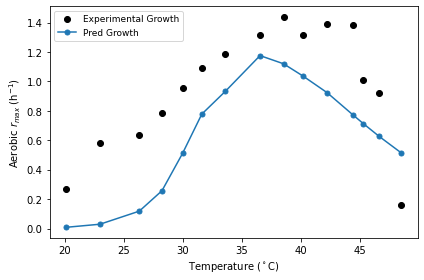

In [6]:
plt.figure()
plt.scatter(dfae_batch.index,dfae_batch['r'].values,label='Experimental Growth',color='k')
plt.plot(dfae_batch.index,rae['growth'],markersize=5,marker='o',label='Pred Growth')
#plt.plot(dfae_batch.index,rae['glucose'],markersize=5,marker='o',label='Glucose')
#plt.plot(dfae_batch.index,rae['oxygen'],markersize=5,marker='o',label='Oxygen')
plt.xlabel('Temperature ($^\circ$C)')
#plt.ylabel('Specific growth rate (h$^{-1}$)')
plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')

plt.legend(fontsize=9,loc='upper left')
plt.tight_layout()
#plt.savefig('../results/prettyCurveTm.png')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(9, 6))
ax2 = ax1.twinx()

ax1.scatter(dfae_batch.index,dfae_batch['r'].values,label='Experimental Growth',color='k')
ax1.plot(dfae_batch.index,rae['growth'],markersize=5,marker='o',label='Pred Growth')

ax2.plot(dfae_batch.index,rae['glucose'],markersize=5,marker='o',label='Glucose Uptake', color='tab:brown')
ax2.plot(dfae_batch.index,rae['oxygen'],markersize=5,marker='o',label='Oxygen Uptake', color='tab:gray')

ax1.set_xlabel("Temperature ($^\circ$C)")
ax1.set_ylabel("Aerobic $r_{max}$ (h$^{-1}$)")

ax2.set_ylabel("Uptake fkux")

fig.legend(fontsize=12)
fig.tight_layout()
#fig.savefig('../results/prettyCurveMoreTm.png')

NGAM is: 3.23
Growth at  20.153299075508016 is:  0.008705632912676764
NGAM is: 3.23
Growth at  23.00151111308503 is:  0.024348183004374448
NGAM is: 3.666948749964016
Growth at  26.331896319367047 is:  0.07373801205794459
NGAM is: 4.228097946953468
Growth at  28.251819864188008 is:  0.13355861557262858
NGAM is: 4.675583853845237
Growth at  29.99421176442104 is:  0.22276478163258465
NGAM is: 5.047267123847456
Growth at  31.62212188446705 is:  0.35105228313622644
NGAM is: 5.44939156263788
Growth at  33.61728633658504 is:  0.5949856178511788
NGAM is: 5.950125048399887
Growth at  36.55299482796005 is:  1.2201484727826755
NGAM is: 6.237403245621997
Growth at  38.54155004207803 is:  1.157717318840788
NGAM is: 6.449817187489966
Growth at  40.20094365636703 is:  1.0878454160687263
NGAM is: 6.681009354243395
Growth at  42.23876395989504 is:  0.9896574253639189
NGAM is: 6.9000236503978725
Growth at  44.453491097574044 is:  0.8731072267448885
NGAM is: 6.974987953458825
Growth at  45.28989924561603

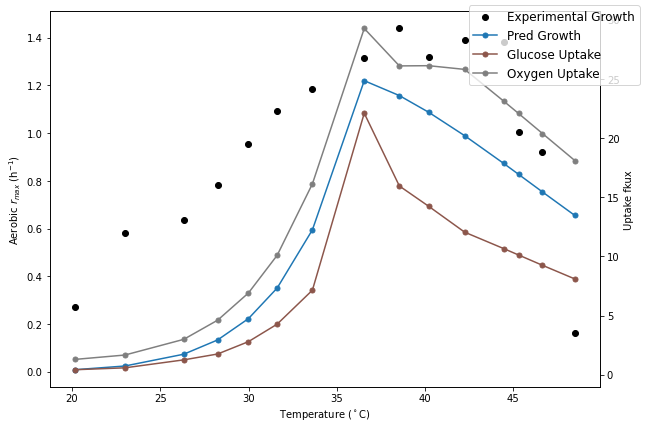

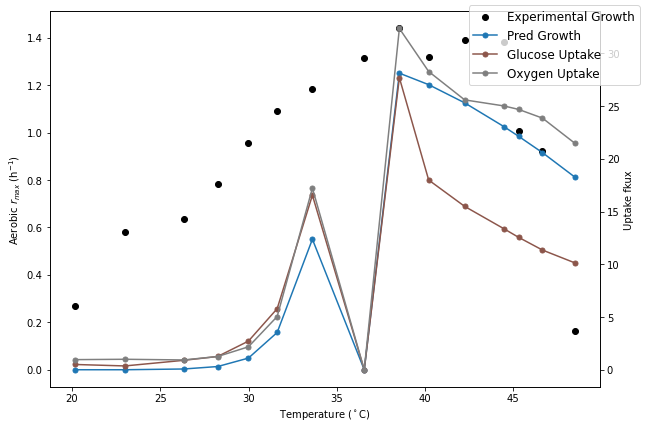

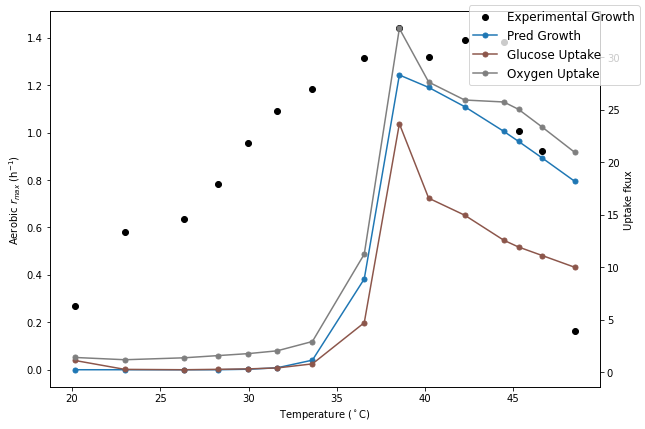

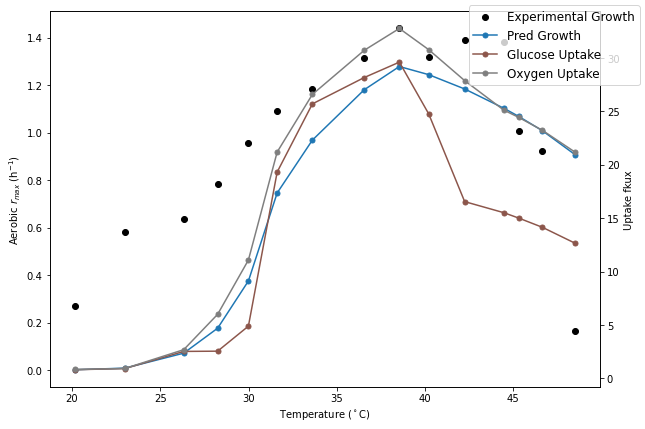

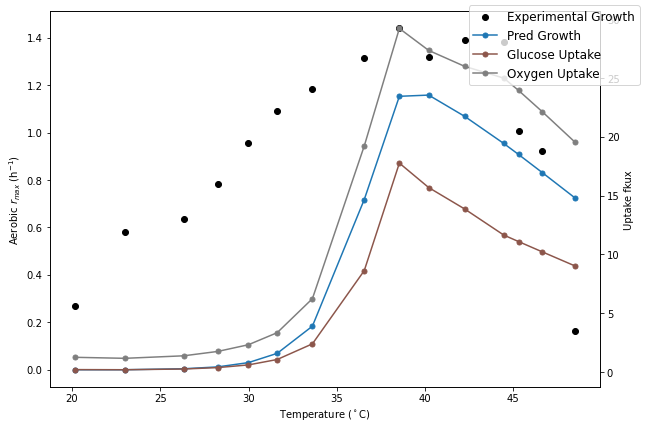

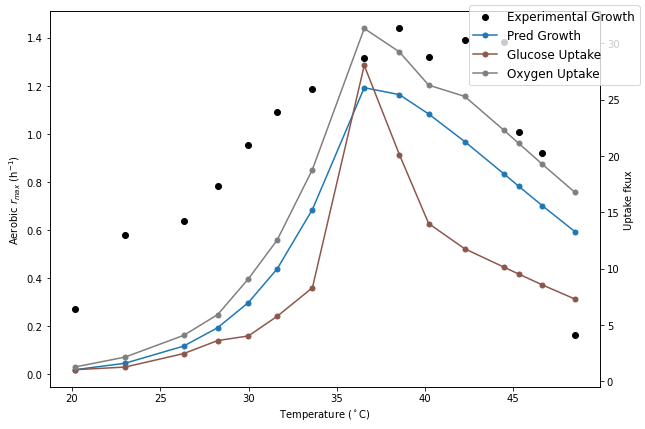

In [7]:
for i in range(35,41):
    if i == 35:
        params = tempDep.sample_data_uncertainty_with_constraint_increasing_topt(params)
        rae = aerobic(params)

    else:
        newParams = tempDep.sample_data_uncertainty_with_constraint_random_topt(params)
        rae = aerobic(newParams)
    
    fig, ax1 = plt.subplots(figsize=(9, 6))
    ax2 = ax1.twinx()

    ax1.scatter(dfae_batch.index,dfae_batch['r'].values,label='Experimental Growth',color='k')
    ax1.plot(dfae_batch.index,rae['growth'],markersize=5,marker='o',label='Pred Growth')

    ax2.plot(dfae_batch.index,rae['glucose'],markersize=5,marker='o',label='Glucose Uptake', color='tab:brown')
    ax2.plot(dfae_batch.index,rae['oxygen'],markersize=5,marker='o',label='Oxygen Uptake', color='tab:gray')

    ax1.set_xlabel("Temperature ($^\circ$C)")
    ax1.set_ylabel("Aerobic $r_{max}$ (h$^{-1}$)")

    ax2.set_ylabel("Uptake fkux")

    fig.legend(fontsize=12)
    fig.tight_layout()
    fig.savefig("../results/RandomToptTm" + str(i) + ".pdf")